# Transformer implementation in PyTorch

In this notebook I will go trough an PyTorch implementation of transformer based on [Attention is all you need](https://arxiv.org/pdf/1706.03762.pdf) paper.

First, I will implement just the Encoder part and train it on language modeling task which is predicting the next word in the sentence given the beginning. The model will be able to generate new sentences once it's trained. Then I will add the Decoder and train the whole Transformer on machine translation task. 

Troughout this notebook I **use some of the illustrations from the exceptional [Illustrated transformer](https://jalammar.github.io/illustrated-transformer) blog post by *Jay Alammar***. I highly recommend you to take a look at it. 


## Dataset

For language modeling task I will use english sentences from a small [Eng-Fra](https://raw.githubusercontent.com/mf1024/transformers/master/fra-eng/fra.txt) dataset. The dataset consists of 170k sentences.

I wrote an pytorch [Dataset](https://github.com/mf1024/transformers/blob/master/fra_eng_dataset.py) to process the sentences. I tokenize the sentences using word_tokenizer from nltk library, nothing too fancy. 

Here are some sentence exeamples:

>**He said nothing, which made her angry.**

>**We have six lessons a day.**

>**Were you able to solve the problem?**

>**How long does it take to get to the stadium?**

>**No matter how long it takes, I will finish the work.**




## Language modeling

Language modeling is predicting the probabilities of the next word given the previous words in the sequence. 
With a slight modification the Transformer Encoder can be trained on the Language modeling task. 

The input of the Encoder is the whole sentence and the targeted output is the sentence shifted by one so that the corresponding output for each word is the next word.

## Transformer architecture:

<img src="imgs/transformer.png">

The key idea of Transformer is to avoid using [reccurence](https://arxiv.org/abs/1409.3215) at all for encoding and decoding variable-length sequences. That solves issues with long-range dependencies and the amount of computation that can be parallelized.

The transformer consists of two parts - the Encoder and the Decoder. They are both very similar in their structure but different in few aspects. 

## The Encoder

<img src="imgs/encoder.png">

The first Encoder layer reads the embedding vectors of the whole sentence, applies self-attention to the sentence, does feed-forward transformation on each of the vectors and outputs vectors of the exactly same dimensions. The second layer does the same to the first layer outputs and so on until the last layer. 

## The Self-Attention

The first step in the self-attention is to calculate the **Key**, **Value** and **Query** vectors for each of the embedding vector. It is done by applying linear transformation on the embedding vector. 

Then for each embedding the **Query** vector is used to find the score with other **Keys** in the sentence or in other words what amount of attention we want to pay to other embeddings int the sentence. Then the similarity of the **Query** and **Keys** of other words in the sentence turns into attention vector of weights which tells how much of the **Value** of the corresponding word of we want to factor in into the new embedding value. The new embedding value is weighted sum of all word **Values** form the sentence.

<img src="imgs/selfattention.png">

These operations can be vectorized and done in a few matrix operations where **Q,K** and **V** (queries, keys, values in the code) are matrices containing Queries, Keys and Values for each of the word in the sentence and Z contains the resulting embeddings:

<img src="imgs/vectorized_self_attention.png">

## Masking for language modeling

There is one small modification I've made to the Encoder so that it can be used for the language modelling task - subsequent Value element masking, which allows self-attention to attend only to current and the previous words in the sentence. The input of the Encoder is the whole sentence and the targeted output is the sentence shifted by one so that the corresponding output for each word is the next word. Without masking the subsequent words the model could simply attend to the next word in the input and output it but with the masking it has to figure out the next word from the previous sequence.


In [13]:
import torch
from torch import nn
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'

In [2]:
class SelfAttentionHead(nn.Module):
    def __init__(self, d_model):
        super().__init__()

        self.d_model = d_model
        self.K = nn.Linear(d_model, d_model)
        self.V = nn.Linear(d_model, d_model)
        self.Q = nn.Linear(d_model, d_model)

    def forward(self, src, src_padding_mask, src_subsq_mask):
        # src shape: [N, SEQ, D_MODEL]

        keys = self.K.forward(src)
        values = self.V.forward(src)
        queries = self.Q.forward(src)
        
        sqrt_d = self.d_model ** 0.5

        att = torch.matmul(queries, keys.transpose(1,2)) / sqrt_d
        # att shape: [N, SEQ, SEQ]
        # Broadcast padding mask to word attentions so that word attention does not attend to positions outside the sentence
        att = att + src_padding_mask.transpose(1,2)
        # Add subsequent mask so that each position can attend only itself and the previous elements
        att = att + src_subsq_mask.unsqueeze(0)
        att_softmax = torch.softmax(att, dim=2)
        # att_softmax shape: [N, SEQ, SEQ]
        out = torch.matmul(att_softmax, values)
        # out shape: [N, SEQ, D_MODEL]

        return out

## Multihead attention

Multihead attention is concatenation of many self-attention instances. The intuition of multihead attention is that each of the heads can learn to pay attention to different types of things.

The outputs of the heads are concatinated and then linearly transformed into regular sized embeddings. 

In [3]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()

        self.num_heads = num_heads
        self.heads = nn.ModuleList([SelfAttentionHead(d_model) for i in range(num_heads)])
        self.linear = nn.Linear(num_heads * d_model, d_model)

    def forward(self, src, src_padding_mask, src_subsq_mask):

        out_cat = None
        for i in range(self.num_heads):
            if i == 0:
                out_cat = self.heads[i].forward(src, src_padding_mask, src_subsq_mask)
            else:
                out_cat = torch.cat([out_cat, self.heads[i].forward(src, src_padding_mask, src_subsq_mask)], dim=2)

        ret = self.linear.forward(out_cat)

        return ret

## Encoder layer

In [4]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_att_heads, ff_dim = 2048, dropout = 0.1):
        super().__init__()

        self.multihead_attention = MultiHeadAttention(d_model, num_att_heads)
        self.att_sublayer_norm = torch.nn.LayerNorm(d_model)

        self.linear1 = nn.Linear(d_model, ff_dim)
        self.dropout1 = nn.Dropout(dropout)
        self.linear2 = nn.Linear(ff_dim, d_model)
        self.dropout2 = nn.Dropout(dropout)
        self.lin_sublayer_norm = torch.nn.LayerNorm(d_model)
        self.relu = nn.ReLU()

    def forward(self, src, src_padding_mask, src_subsq_mask):

        #Self Attention sub-block      
        res1 = src #Storing tmp values for residual connection
        x = self.multihead_attention.forward(src, src_padding_mask, src_subsq_mask)
        x = self.att_sublayer_norm.forward(res1 + self.dropout1(x)) #Dropout, residual connection and normalization

        #Feed-Forward sub-block    
        res2 = x #Storing tmp values for residual connection
        x = self.linear2(self.relu(self.linear1.forward(x)))
        x = self.lin_sublayer_norm(res2 + self.dropout2(x)) #Dropout, residual connection and normalization

        return x


## The Encoder

In [5]:
class Encoder(nn.Module):
    def __init__(self, num_layers, d_model, num_att_heads):
        super().__init__()
        self.layers = nn.ModuleList([EncoderLayer(d_model, num_att_heads) for i in range(num_layers)])
        self.norm = nn.LayerNorm(d_model)

    def forward(self,src, src_padding_mask, src_subsq_mask):
        x = src
        for layer in self.layers:
            x = layer.forward(x, src_padding_mask, src_subsq_mask)

        x = self.norm.forward(x)

        return x

## Positional Encoding

The attention module itself have no information about the position of other word embeddings in the sentence. In NLP and other sequential data tasks the order of the sequence is critical. To solve this issue the authors of the paper introduce the Positional Encoding method. First they generate a vector containing information about the position in the same size as the embedding and then simply add this vector to the word embedding and hope that the model will learn to recognize it.

They use the following function to generate the positional information: 
<img src="imgs/pos_enc.png">


In [6]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.d_model = d_model

        self.sin_args = torch.zeros(1, self.d_model).to(device)
        self.cos_args = torch.zeros(1, self.d_model).to(device)
        for i in range(self.d_model//2):
            self.sin_args[0,i * 2] = 10000**(2.*i/self.d_model)
            self.cos_args[0,i * 2 + 1] = 10000**(2.*i/self.d_model)

        self.sin_args_mask = (self.sin_args > 1e-10).float()
        self.sin_args = self.sin_args + (self.sin_args < 1e-10).float()

        self.cos_args_mask = (self.cos_args > 1e-10).float()
        self.cos_args = self.cos_args + (self.cos_args < 1e-10).float()

    def forward(self, x):
        for pos in range(x.size()[-2]):
            x[:,pos,:] = x[:,pos,:] + \
                         torch.sin(pos / self.sin_args) * self.sin_args_mask + \
                         torch.cos(pos / self.cos_args) * self.cos_args_mask

        return x


Here is a vizualization of the positional encoding vectors. Each row is an encoding for a word. 

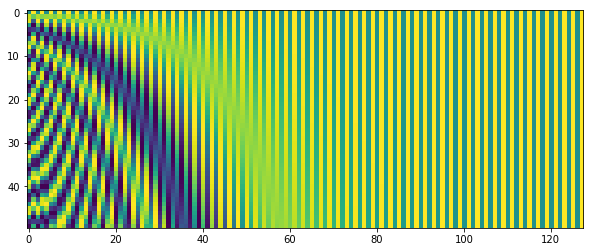

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

positional_enc = PositionalEncoding(128).to(device)
data = torch.zeros(1, 50, 128).to(device)
data_pos_enc = positional_enc.forward(data)

enc_np = data_pos_enc.squeeze(dim=0).to('cpu').numpy()
fig, ax = plt.subplots(figsize=(12, 4))
ax.imshow(enc_np)
plt.show()

In [8]:
class Transformer(nn.Module):
    def __init__(self, num_layers, d_model, num_att_heads, input_dict_size, output_dict_size):
        super().__init__()
        
        self.input_emb = nn.Embedding(input_dict_size, d_model)

        self.positional_encoder = PositionalEncoding(d_model)
        self.encoder = Encoder(num_layers, d_model, num_att_heads)
        self.decoder = None

        self.outp_logits = nn.Linear(d_model, output_dict_size)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, src, src_padding_mask, src_subsq_mask):

        x = self.input_emb.forward(src.squeeze(dim=2))
        x = self.positional_encoder.forward(x)

        x = self.encoder.forward(x, src_padding_mask, src_subsq_mask)
        x = self.outp_logits.forward(x)
        x = self.softmax(x)

        return x


### Some helper functions

In [9]:
def get_square_subsequent_mask(seq_len):
    mask = (torch.triu(torch.ones(seq_len, seq_len).to(device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

def get_padding_mask(input, val1 = float('-inf'), val2 = float(0.0)):
    mask = torch.ones(input.size()).to(device)
    mask = mask.float().masked_fill(input == 0, val1).masked_fill(input > 0, val2)
    return mask


def get_one_hot(x, out_dim, mask):
    tens = x.view(-1)
    tens_one_hot = torch.zeros(list(tens.size()) + [out_dim]).to(device)
    for i in range(len(tens)):
        tens_one_hot[i,tens[i]] = 1

    tens_one_hot = tens_one_hot.view(list(x.size()) + [out_dim])
    tens_one_hot = tens_one_hot * mask
    return tens_one_hot.to(device)

### Model definition, Dataset, optimizer and hyperparams

In [10]:
from fra_eng_dataset import FraEngDataset, fra_eng_dataset_collate
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

BATCH_SIZE = 128
LEARNING_RATE = 1e-4
EPOCHS = 20
STORE_MODELS = True
models_path = 'models'

if not os.path.exists(models_path):
    os.mkdir(models_path)

dataset = FraEngDataset()
sentences_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, collate_fn=fra_eng_dataset_collate)

in_dict_size = dataset.get_eng_dict_size()

transformer_model = Transformer(
    num_layers=6,
    d_model=512,
    num_att_heads=8,
    input_dict_size=in_dict_size,
    output_dict_size=in_dict_size # We do language modeling so we will use in_dict_size for output as well
).to(device)

optimizer = torch.optim.Adam(transformer_model.parameters(), lr = 1e-4)

170190


### Function to generate senteces one by one using our trained model
Will use it after each epoch to see how good the model is.

In [11]:
def generate_some_sentences(num_sentences = 25):

    transformer_model.eval()
    with torch.no_grad():
        for i in range(num_sentences):
            snt = torch.ones((1,1,1)).to(device) * dataset.get_eng_start_code()
            snt = snt.long()

            sent_idxes = []

            for i in range(25):
                pred = transformer_model.forward(
                    src = snt,
                    src_padding_mask = torch.zeros_like(snt).float().to(device),
                    src_subsq_mask = get_square_subsequent_mask(snt.size()[1]),
                )
                next_word_softmax = pred[0,i,:].to('cpu').detach().numpy()
                next_word = np.random.choice(len(next_word_softmax), p=next_word_softmax)
                snt = torch.cat([snt, torch.ones((1,1,1)).long().to(device) * next_word], dim=1)

                sent_idxes.append(next_word)

                if next_word == dataset.get_eng_eos_code():
                    break

            sent = ''
            for word_idx in sent_idxes:
                sent = f"{sent} {dataset.eng_token_to_text[word_idx]}"

            print(sent)

    transformer_model.train()

## Training

In [12]:
iterations = 0

for epoch in range(EPOCHS):
    
    train_loss_sum = 0.0
    total_word_count = 0.0
    
    for sentences in sentences_loader:

        src_sentences = sentences['eng_sentences']
        tgt_sentences = []

        #Target sequence is source sequence shifted by one
        for sentence in src_sentences:
            tgt_sentences.append(sentence[1:])

        for sent_idx in range(len(src_sentences)):
            src_sentences[sent_idx] = src_sentences[sent_idx][:-1]
    
        #Create tensors from token lists
        padded_src = pad_sequence(src_sentences, padding_value = 0, batch_first=True).to(device)
        padded_tgt = pad_sequence(tgt_sentences, padding_value = 0, batch_first=True).to(device)

        src_padding_mask = get_padding_mask(padded_src)
        src_subsq_mask = get_square_subsequent_mask(padded_src.size()[1])

        pred = transformer_model.forward(
            src = padded_src,
            src_padding_mask = src_padding_mask,
            src_subsq_mask = src_subsq_mask
        )

        #Mask to zero one hot vectors corresponding to padded elements
        one_hot_mask = get_padding_mask(padded_tgt, val1 = float(0.0), val2 = float(1.0))
        y_one_hot = get_one_hot(padded_tgt.squeeze(dim=2), in_dict_size, mask = one_hot_mask)

        loss = - torch.sum(torch.log(pred) * y_one_hot)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        train_loss_sum += loss.detach().to('cpu').data
        total_word_count += torch.sum(y_one_hot).to('cpu').data
        
    print(f"Epoch {epoch} " + '=' * 60)
    print(f"Total loss per word: {train_loss_sum / total_word_count}")
    print(f"Some generated sentences:")
    generate_some_sentences(num_sentences = 15)
    
    if STORE_MODELS == True:
        model_path = os.path.join(models_path, f'Epoch_{epoch}_model.pt')
        torch.save(transformer_model, model_path)

print("Traing done! Generating some more sentences.")
generate_some_sentences(num_sentences = 50)


Epoch 0 ============================================================
Total loss per word: 3.8989408016204834
Some generated sentences:
 Had ever cut Super off when we unwrapped the rain . <EOS>
 I overstepped the interesting to anabolic two there . <EOS>
 He walked to eat a friend . <EOS>
 Grab ? <EOS>
 What do we have ? <EOS>
 I 'd cried if this is expert . <EOS>
 He asked up when he managed lunch for a accompanied . <EOS>
 Where do you need my proposal ? <EOS>
 You 're books . <EOS>
 I needed to visit an Here . <EOS>
 Do n't give me a lot . <EOS>
 That 's not not more hungry than we can do . <EOS>
 Well , have we ? <EOS>
 I 've never wonder what was doing . <EOS>
 Since , I 'd have been alone . <EOS>


/home/martin/anaconda3/envs/ml/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Transformer. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/martin/anaconda3/envs/ml/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type PositionalEncoding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/martin/anaconda3/envs/ml/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/martin/anaconda3/envs/ml/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type EncoderLayer. It won't be checked for correc

Epoch 1 ============================================================
Total loss per word: 3.268401861190796
Some generated sentences:
 He nodded all morning . <EOS>
 How much do you mind to hear that for ? <EOS>
 She 's not as nice as I really could . <EOS>
 The prime put changed with birthdays . <EOS>
 I 'm hungry . <EOS>
 Ask me the last way he does . <EOS>
 The rebels handed cheated a lot like it rains . <EOS>
 I 've been to foot for dinner . <EOS>
 Tom meant something that somebody will be connected to me . <EOS>
 He told me what else to do . <EOS>
 I can hear this game . <EOS>
 I was grammar old impression of a chance . <EOS>
 I do n't really care . <EOS>
 Part goes out ! <EOS>
 I fell for the bicycle . <EOS>
Epoch 2 ============================================================
Total loss per word: 3.05794620513916
Some generated sentences:
 This letter is received startling . <EOS>
 Do you have something to eat to eat ? <EOS>
 Do you want friends ? <EOS>
 You support a brother . <

 I wish I 'd told you everything should have done more . <EOS>
 I had to meet him . <EOS>
 They wo n't tell you the truth . <EOS>
Epoch 12 ============================================================
Total loss per word: 2.216280937194824
Some generated sentences:
 I 'm ready for Monday . <EOS>
 Something might be dorm , so tell me no wonder what you 're talking about . <EOS>
 You told me that you were busy . <EOS>
 We ca n't fix this anymore . <EOS>
 Tom is still jealous . <EOS>
 I 'm not in good health . <EOS>
 My phone is ruined again . <EOS>
 My uncle is intelligent . <EOS>
 I am sorry , I did n't recognize you . <EOS>
 Are you the one who caused this mess ? <EOS>
 I need to give you some declined . <EOS>
 He paid two dollars off his telephone 's cigarette . <EOS>
 Do you remember when we first met ? <EOS>
 Do you have a flashlight I can write of sake ? <EOS>
 The news is spacious on the ground . <EOS>
Epoch 13 ============================================================
Total loss